In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

import time

#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'


plt.style.use("seaborn-v0_8-white")

### 1. **Pricing European Options via Monte-Carlo: the Risk-Neutral framework**
----

Within the risk-neutral world of Black-Scholes theory, investor's assumed to expect no more than risk-free rate for an investment they hold within a unit trading time. In essence, risk-preferences of investor's do not play a role, as opposed to the case one would normally demand: more return from a risky asset as compared to a less risky one. In such a world, it is possible to determine the unique price of contingent claims like European options in an arbitrage-free manner. The resulting option premium is intuitive in the sense that the fair price of such a contract is determined by its (risk-neutral) discounted expected pay-off at time $T$: 

$$
\frac{C_t}{Z_t} = \mathbb{E}_{\mathbb{Q}}\left[\frac{C_T}{Z_T}\, \bigg |\, \mathcal{F}_t\right],
$$

where $Z_t = \mathrm{e}^{- \int_{t}^T r_s \mathrm{d}s}$ is the value of zero coupon bond that pays 1 at time $T$, i.e. $Z_T = 1$. 






We can thus estimate the price of a call option by computing the average of a large number of pay-offs. For this we will utilize several steps: 

1. Compute a large number of stock price paths between $t = 0$ and $t = T$, assuming each evolves under geometric Brownian motion (GBM), so that for each simulation $n$ the stock price follows the following stochastic differential equation:

$$
\mathrm{d}S^{(n)}_t = r\,S^{(n)}_t\,\mathrm{d}t + \sigma\,S^{(n)}_t\,\mathrm{d}W_t \quad\quad\quad \mathrm{d}W_t \sim \mathcal{N}(0,\mathrm{d}t).
$$

2. Compute the option price for each simulation via: 

$$
C^{(n)}_0 = \mathrm{e}^{- r T}\, C^{(n)}_T,\quad\quad\quad\quad C^{(n)}_T = \textrm{max}(S^{(n)}_T - K, 0) = (S^{(n)}_T - K, 0)_{+}
$$

where we assumed a constant risk-free rate $r$ for the time range of each simulation, $t \in [0,T]$ and $K$ is the strike price of the contract. We can then repeat the simulation $M$ times to derive an estimate for the option price as the average of the $M$ outcomes: 

3. Compute the option price as the average of $M$ simulations: 

$$
\hat{C}_0 = \frac{1}{M} \sum_{n = 1}^{M} C^{(n)}_0
$$

### 1.1 Problem Statement: Standard error of the estimate and how to reduce it
----

Like all estimates, $\hat{C}_0$ has some error in it due to the fact that we are taking an average by sampling random variables such that outcome itself is random. We quantify this error by the so called Standard Error of estimation, which is given by the standard deviation of $C^{(n)}_0$ divided by the square root of the number of simulations $M$: 

$$

\textrm{SE}(\hat{C}_0) = \frac{\sigma\left(C^{(n)}_0\right)}{\sqrt{M}},\quad\quad\quad \sigma\left(C^{(n)}_0\right) = \sqrt{\frac{1}{M - 1} \sum_{n = 1}^{M} (C^{(n)}_0 - \hat{C}_0)^2}
$$

In order to make our estimates more stable, we can of course increase the number of simulations $M \to \infty$. However, this is computationally costly. To deal with this issue there are several variance reduction measures are introduced which is what we are going to explore here. 

For this purpose, we will explore the effectiveness of two variance reduction methods through the vanilla European options. Note that doing so for contracts of the latter type is redundant using Monte-Carlo simulations as we already have analytical solutions for such options within the Black-Scholes world where the underlying stock follows GBM. Our main goal here is therefore to illustrate the variance reduction methods in a simple example. 

In the real world however, such methods are only valuable when valuing complex derivatives via Monte-Carlo simulations. 

Keeping this in mind, the two methods we will explore are:

1. Use of Antithetic Variates
2. Use of Control Variates

### 1.2 **Pricing European Vanilla Options without variance reduction**
-----

First thing first, we focus on the pricing via Monte-Carlo simulation in the absence of variance reduction methods. 

Using the Ito calculus rules the log process for the stock price satisfies the following dynamics in the risk-neutral world: 


$$
\mathrm{d}\ln S^{(n)}_t = \left(r - \frac{\sigma^2}{2}\right)\,\,\mathrm{d}t + \sigma\,\,\mathrm{d}W_t \quad\quad\quad \mathrm{d}W_t \sim \mathcal{N}(0,\mathrm{d}t).
$$

Focusing on the discretized version appropriate for the simulations, we have 

$$
\ln\left(\frac{S_{t + \Delta t}}{S_t}\right) = \left(r - \frac{\sigma^2}{2}\right)\,\,\Delta t + \sigma \left(W_{t+\Delta t} - W_t\right)
$$

which implies 

$$
S_{t + \Delta t} = S_t \exp\bigg[\left(r - \frac{\sigma^2}{2}\right)\,\,\Delta t  + \sigma \left(W_{t+\Delta t} - W_t\right)\bigg]
$$

where 

$$
W_{t+\Delta t} - W_t \sim \mathcal{N}(0,\Delta t) \sim \sqrt{\Delta t}\, \mathcal{N}(0,1) \sim\sqrt{\Delta t}\, Z
$$

with Z denoting a standard normal random variable. 

Note: It is important to emphasize that when the underlying follows a GBM (Brownian motion scales with time deterministically), we do not need to discretize the time steps to generate stock price paths, because the solution above is exact and gives the following at the time of maturity: 

$$
S_T = S_0 \exp\bigg[\left(r - \frac{\sigma^2}{2}\right)\,T  + \sigma \sqrt{T} Z_T\bigg].
$$

So in practice to get the option price we can just use the expression above $M$ times and take the average of the discounted pay-off!

In essence, this is the case because European vanilla options (in the Black-Scholes world) are path independent, simply because only the event at the maturity which determines whether the option is in the money $S_T > K$ or not $S_T < K$ is important. However for more complicated options that depend on the path such as:

- Asian options (average price)

- Barrier options (knock-in/knock-out)

- Lookback options

time step discretization is meaningful.


In [153]:
import yfinance as yf

ticker = yf.Ticker("TD")

expiry_dates = ticker.options  # Lists available expiration dates

print(f'Expiry dates for available option contracts on {ticker}')
for expiry in expiry_dates: 
    
    print(f"Date: {expiry}")

Expiry dates for available option contracts on yfinance.Ticker object <TD>
Date: 2025-06-20
Date: 2025-07-18
Date: 2025-10-17
Date: 2026-01-16
Date: 2027-01-15


In [154]:
# pick an expiry date

chain = ticker.option_chain("2025-07-18")

# save the option chain for future use 

chain.calls.head(20).to_csv('TD_Calls_2025-07-18.csv', index = False)

In [155]:
td_opt_chain_df = pd.read_csv('TD_Calls_2025-07-18.csv')

td_opt_chain_df.head(20)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,TD250718C00040000,2025-04-23 15:12:10+00:00,40.0,22.65,23.30,25.80,0.00,0.000000,1,1,0.663089,True,REGULAR,USD
1,TD250718C00042500,2025-02-27 17:38:54+00:00,42.5,17.00,15.70,19.90,0.00,0.000000,5,40,0.000010,True,REGULAR,USD
2,TD250718C00045000,2025-04-04 17:19:38+00:00,45.0,12.02,17.20,20.80,0.00,0.000000,40,11,0.841310,True,REGULAR,USD
3,TD250718C00047500,2025-03-14 16:04:02+00:00,47.5,11.50,12.90,14.00,0.00,0.000000,1,3,0.000010,True,REGULAR,USD
4,TD250718C00050000,2025-04-23 19:24:12+00:00,50.0,12.45,13.50,15.30,0.00,0.000000,1,233,0.570317,True,REGULAR,USD
5,TD250718C00052500,2025-04-15 19:36:19+00:00,52.5,8.50,0.00,0.00,0.00,0.000000,3,0,0.000010,True,REGULAR,USD
6,TD250718C00055000,2025-05-12 15:37:06+00:00,55.0,8.90,9.40,10.00,0.00,0.000000,1,271,0.362067,True,REGULAR,USD
7,TD250718C00057500,2025-05-16 15:41:00+00:00,57.5,7.47,7.00,7.70,0.67,9.852935,1,252,0.318366,True,REGULAR,USD
8,TD250718C00060000,2025-05-16 13:59:46+00:00,60.0,5.50,5.00,5.20,-0.20,-3.508769,12,895,0.239754,True,REGULAR,USD
9,TD250718C00062500,2025-05-13 19:59:58+00:00,62.5,2.99,3.00,3.20,0.00,0.000000,3,716,0.207039,True,REGULAR,USD


We focus on a call option struck at 65 to get the implied volatility and determine its price.

In [156]:
# Set some parameters we will utilize globally

S0 = ticker.history(period="1d")['Close'].iloc[-1] # current stock price

K = 65 #strike for the call option to value

# Filter that option
call_to_look = td_opt_chain_df[td_opt_chain_df.strike == K].iloc[0]

# market price of the option
market_price = call_to_look.lastPrice # market price of the option

# maturity in years 
T = ((datetime.date(2025,7,18) - datetime.date.today()).days)/365 # Time to maturity

# Implied volatility 
sigma = call_to_look['impliedVolatility'] #annualized volatility

# risk free rate 
r = 2.65/100 #from the 3-month Canadian T-bill yield

# number of MC simulations
M = 1000 

# Number of Time Steps 
N = 50

In [5]:
import numpy as np
from scipy.stats import norm

def black_scholes_price(S, K, T, r, sigma, type='c'):
    """
    Compute the Black-Scholes price for a European option.
    
    Parameters:
    -----------
    S : float or np.ndarray
        Current stock price
    K : float or np.ndarray
        Strike price
    T : float or np.ndarray
        Time to maturity in years
    r : float
        Risk-free interest rate (annualized)
    sigma : float or np.ndarray
        Volatility of the underlying asset (annualized)
    type : str
        'c' for a call option, 'p' for a put option
    
    Returns:
    --------
    price : float or np.ndarray
        The option price
    """
    S = np.asarray(S)
    K = np.asarray(K)
    T = np.asarray(T)
    sigma = np.asarray(sigma)
    
    # Handle the edge case where T = 0, to avoid division by zero
    intrinsic_value = np.where(type == 'c',
                               np.maximum(S - K, 0),
                               np.maximum(K - S, 0))
    
    epsilon = 1e-10
    denom = sigma * np.sqrt(T)
    denom = np.where(denom == 0, epsilon, denom)

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / denom
    d2 = d1 - denom

    if type == 'c':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif type == 'p':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Please confirm option type: 'type' must be 'call' or 'put'")

    return np.where(T == 0, intrinsic_value, price)


In [158]:
bs_price = black_scholes_price(S0,K,T,r,sigma, type = 'c')
print(f"Black-Scholes price: {bs_price:.3f}")

Black-Scholes price: 1.730


In [159]:
# Summarize the contract details for later use 

option_dict = {"Contract Terms": ['Strike', 'Time to Expiry [years]', 
                                  'Asset price', 'Vol', 'Risk-free rate',
                                  'BS price', 'Market Price', 'Num time steps', 'Num MC simulations'],
               "Value": [K, T, S0, sigma, r, bs_price.round(4), market_price, N, M]
               }

contract_df = pd.DataFrame(option_dict)

contract_df

,Contract Terms,Value
0,Strike,65.000000
1,Time to Expiry [years],0.172603
2,Asset price,64.309998
3,Vol,0.179696
4,Risk-free rate,0.026500
5,BS price,1.730500
6,Market Price,1.550000
7,Num time steps,50.000000
8,Num MC simulations,1000.000000


As I mentioned above we actually do not need to discretize the interval $[0,T]$ for path independent assets like European option, to determine its price. Below I first implement via single step drawing from standard normal distribution at the final time step $T$.

#### 1.2.1 Monte-Carlo in one go
---

In [160]:

Z = np.random.normal(0, 1, M)
ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

payoffs = np.maximum(ST - K, 0)
discounted_payoffs = np.exp(-r * T) * payoffs

price_estimate = np.mean(discounted_payoffs)

SE = np.std(discounted_payoffs, ddof=1) / np.sqrt(M)

print("Single-step MC:")
print("----------------")
print(f"Estimate for Call Price on TD struck at {K}: {price_estimate:.4f} +/- {SE:.4f}")

Single-step MC:
----------------
Estimate for Call Price on TD struck at 65: 1.6963 +/- 0.0894


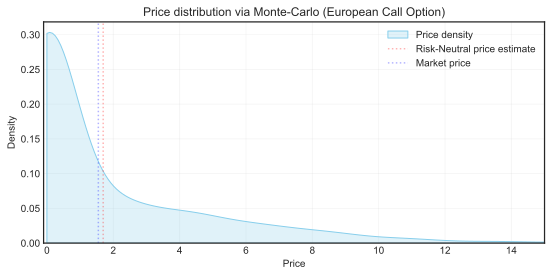

In [161]:
# Plot density
plt.figure(figsize=(9, 4))
sns.kdeplot(discounted_payoffs, bw_adjust=1.2, fill=True, cut=discounted_payoffs.min(), color='skyblue', label='Price density')
plt.axvline(np.mean(discounted_payoffs), alpha = 0.3, color='red', linestyle='dotted', label='Risk-Neutral price estimate')
plt.axvline(market_price, alpha = 0.3, color='blue', linestyle='dotted', label='Market price')
plt.xlim(-0.1, 15)
plt.title("Price distribution via Monte-Carlo (European Call Option)")
plt.xlabel("Price")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha = 0.2)
plt.show()

Notice that price and therefore the pay-off of the option has a long right skewed tail. This is expected for a European call option due its asymmetric pay-off profile. 

#### 1.2.2 Multi-Step Monte-Carlo
----

In [162]:
 #N = 50 #change if you like 
dt = T/N

mudt = (r - 0.5 * sigma**2) * dt 

voldt = sigma * np.sqrt(dt)
lnS0 = np.log(S0)

# initial values for the sum of all Call pay-offs and its squre
sum_CT = 0
sum_CTsq = 0

for i in range(M):
    
    lnSt = lnS0
    
    # add time increments of the log-process for each time step 
    for j in range(N):
        
        lnSt += mudt + voldt * np.random.normal()
    
    # to get the final stock price    
    S_T = np.exp(lnSt)
    C_T = max(S_T - K, 0)
    
    # add the results of each simulation
    sum_CT += C_T
    sum_CTsq += C_T ** 2
    
# price as the discounted average pay-off

call_price = (sum_CT/M) * np.exp(-r * T)

std = np.sqrt((sum_CTsq - (sum_CT**2)/M) * np.exp(-2*r*T) / (M - 1)) 

standard_error = std / np.sqrt(M)


print("Multi-step MC:")
print("----------------")
print(f"Estimate for Call Price on TD struck at {K}: {call_price:.4f} +/- {standard_error:.4f}")        


Multi-step MC:
----------------
Estimate for Call Price on TD struck at 65: 1.6433 +/- 0.0850


#### 1.2.3 Vectorized Multi-Step Monte-Carlo
----

In [163]:
# variables
# N = 1 # time-step can be 1 as well due to path independence of the option's value 

init_time = time.time()

dt = T/N
mudt = (r - 0.5 * sigma**2) * dt 
voldt = sigma * np.sqrt(dt)
lnS0 = np.log(S0)


# vectorized Monte Carlo

Z = np.random.normal(size = (N,M))
delta_lnSt = mudt + voldt * Z
lnSt = lnS0 + np.cumsum(delta_lnSt, axis = 0) # cumuluative sum over the time axis, shape 1 x M
lnSt = np.concatenate((np.full(shape = (1,M), fill_value=lnS0), lnSt)) # add the first row of the matix as the initial log price

S_T = np.exp(lnSt)
C_T = np.maximum(S_T - K, 0)
   
# price as the discounted expected pay-off at T  
C_0 = np.exp(-r*T) * (np.sum(C_T[-1])/M)


# std and standard error 
std = np.sqrt( np.sum((C_T[-1] * np.exp(-r*T) - C_0)**2) / (M - 1)) 
se = std / np.sqrt(M)

mc_time = time.time() - init_time

print('Vectorized Multi-step MC:')
print("--------------------------")
print(f"Estimate for Call Price on TD struck at {K}: {C_0:.4f} +/- {se:.4f}")    
print(f"Computation time {mc_time:.4f}")    

Vectorized Multi-step MC:
--------------------------
Estimate for Call Price on TD struck at 65: 1.7381 +/- 0.0887
Computation time 0.0050


### 1.3 **Variance reduction via Antithetic Variate(s)**
----
The main idea behind the use of antithetic variate for the reduction of estimation variance in Monte-Carlo methods is very much similar to the variance reduction via diversification in modern portfolio theory (MPT). Recall that within MPT it is possible to reduce the variance of returns for a long only portfolio, for example by considering two negatively correlated assets with appropriate weights within the portfolio. As we will see, the idea in variance reduction for MC estimates with antithetic variate(s) does essentially rely on the same idea. 

First, remind ourselves the **Monte-Carlo estimator** of the call option price:

$$
\hat{C}_{0,\textrm{MC}} = \frac{1}{M} \sum_{n = 1}^{M} C_0(Z^{(n)}_T), 
$$

where 

$$
C_0(Z_T) = \mathrm{e}^{-r T}\, \textrm{max}\left(S_0\cdot \exp\bigg[\left(r - \frac{\sigma^2}{2}\right)\,T  + \sigma \sqrt{T} Z_T\bigg] - K, 0\right)
$$

is the **discounted pay-off** under the risk-neutral pricing. So to estimate the price of this vanilla European option, we essentially draw from a normal distribution at the expiry of the contract and repeat it M times and take the average. Note that the Monte-Carlo estimator is unbiased because the it's expectation does precisely give the quantity we are trying estimate:

$$
\mathbb{E}[\hat{C}_{0,\textrm{MC}}] = \frac{1}{M}\sum_{n = 1}^{M}\mathbb{E}[C_0(Z^{(n)}_T)] = \mathbb{E}[C_0(Z^{(n)}_T)] =  \mathbb{E}[C_0(Z_T)]
$$

because all $Z^{(n)}$ are i.i.d random variables. 



Now consider another hypothetical asset $\tilde{S}$ whose log increments satisfy GBM with the same risk-neutral drift, volatility. Furthermore, we assume that the incremental log process (aka log-returns) does exhibit perfect negative correlation with $S$: 

$$
\mathrm{d}\ln S^{(n)}_t = \left(r - \frac{\sigma^2}{2}\right)\,\,\mathrm{d}t + \sigma\,\,\mathrm{d}W^{(n)}_t .
$$

$$
\mathrm{d}\ln \tilde{S}^{(n)}_t = \left(r - \frac{\sigma^2}{2}\right)\,\,\mathrm{d}t - \sigma\,\,\mathrm{d}W^{(n)}_t .
$$

Noting $\mathrm{d}W_t \sim \sqrt{\mathrm{d}t} Z$, and assuming the same initial price, we have the terminal distributions of the assets:

$$
S_T^{(n)} = S_0 \exp\bigg[\left(r - \frac{\sigma^2}{2}\right)\,T  + \sigma \sqrt{T} Z_T^{(n)}\bigg].
$$

$$
\tilde{S}_T^{(n)} = S_0 \exp\bigg[\left(r - \frac{\sigma^2}{2}\right)\,T  - \sigma \sqrt{T} Z_T^{(n)}\bigg].
$$

Which implies that the terminal distribution of the hypothetical asset can be derived via the mirror transformation $Z_T \to -Z_T$, i.e $\tilde{S}_T = S_T(-Z)$. Accordingly, the pay-off for the options on these assets will be related via the same transformation, and so does their discounted pay-offs for each simulation $n$.

The crux of the variance reduction method via antithetic variate(s) relies on the **antithetic estimator** of the option price which is constructed as a portfolio of two call options on assets $S$ and $\tilde{S}$. Due to symmetry we noted above $\tilde{S}_T = S_T(-Z)$, we thus write the price estimator as a superposition of the discounted pay-offs of call options on these assets as:

$$
\hat{C}_{0,\textrm{anti}} = \frac{1}{M} \sum_{n = 1}^{M} \frac{1}{2}\left[\,C_0\left(Z^{(n)}_T\right) + C_0\left(-Z^{(n)}_T\right)\,\right].
$$

Similar to the Monte-Carlo estimator, the **antithetic estimator** above is also an *unbiased estimator* of the discounted expected pay-off: 

$$
\mathbb{E}[\hat{C}_{0,\textrm{anti}}] = \frac{1}{M} \sum_{n = 1}^{M} \frac{1}{2} \left[\,\mathbb{E}\left[C_0\left(Z^{(n)}_T\right)\right] + \mathbb{E}\left[C_0\left(-Z^{(n)}_T\right)\right]\,\right] = \mathbb{E}[C_0(Z^{(n)}_T)] = \mathbb{E}[C_0(Z_T)],
$$

where we used the fact that $\mathbb{E}[f(Z_T)] = \mathbb{E}[f(-Z_T)]$ for any integrable function $f$ as long as $Z_T \sim \mathcal{N}(0,1)$. Note that this follows from the fact that normal distribution is symmetric around 0. 

As an unbiased estimator, **antithetic estimator** appears as good as MC estimator, but in fact it is better because the variance of the **antithetic estimator** is smaller than the variance of the MC estimator.

**Variance of the antithetic estimator**: 

To show the claim above we consider 

$$
\mathbb{V}\left[\hat{C}_{0,\textrm{anti}}\right] = \frac{1}{M}\, \mathbb{V}\left[\hat{C}^{(n)}_{0,\textrm{anti}}\right]
$$

where we used the independence of the antithetic estimator for each simulation $n$: 

$$
\hat{C}^{(n)}_{0,\textrm{anti}} \equiv \frac{1}{2}\left[\,C_0\left(Z^{(n)}_T\right) + C_0\left(-Z^{(n)}_T\right)\,\right]
$$

Taking the variance of the sum of two correlated random variables $C_0\left(Z_T\right),C_0\left(-Z_T\right)$, we have 

$$
\mathbb{V}\left[\hat{C}^{(n)}_{0,\textrm{anti}}\right] = \frac{1}{2} \left[ \sigma^2 + \textrm{Cov}\left(C_0\left(Z_T^{(n)}\right),C_0\left(-Z_T^{(n)}\right)\right) \right]
$$

where $\sigma$ is the standard deviation of $C_0(Z_T)$ as in the standard MC approach. Notice that if we were not considering antithetic variable, the covariance in the second term would be $\sigma^2$ as in the standard MC approach, leading to the results we derived earlier.

However, for our case, the covariance of the pay-offs is actually negative. This is because for monotonic pay-offs like the call option pay-offs, $Z \to -Z$ transformation has an opposite effect on the value of $C_0$: e.g. while for a given r.v $Z$ $C_0(Z)$ ends up in the money, the second option $C_0(-Z)$ will be otm. The opposite movement of the pay-offs imply a negative correlation / covariance, reducing the variance of the antithetic estimator: 

$$
\mathbb{V}\left[\hat{C}_{0,\textrm{anti}}\right] = \frac{1}{2M}\left[ \sigma^2 + \textrm{Cov}\left(C_0\left(Z_T^{(n)}\right),C_0\left(-Z_T^{(n)}\right)\right) \right],
$$

where 

$$
 \textrm{Cov}\left(C_0\left(Z_T^{(n)}\right),C_0\left(-Z_T^{(n)}\right)\right) < 0
$$

#### 1.3.1 Monte-Carlo with antithetic variate: Single step simulation
----

In [164]:
Z = np.random.normal(0, 1, M)

ST1 = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
ST2 = S0 * np.exp((r - 0.5 * sigma**2) * T - sigma * np.sqrt(T) * Z)

disc_payoffs_1, disc_payoffs_2 = np.exp(-r * T) *  np.maximum(ST1 - K, 0), np.exp(-r * T) * np.maximum(ST2 - K, 0)

price_estimate_anti = np.mean(0.5 * (disc_payoffs_1 + disc_payoffs_2))

SE = np.std(0.5 * (disc_payoffs_1 + disc_payoffs_2), ddof=1) / np.sqrt(M)

print("Single-step MC with antithetic variates:")
print('-----------------------------------------')
print(f"Estimate for Call Price on TD struck at {K}: {price_estimate_anti:.4f} +/- {SE:.4f}")

Single-step MC with antithetic variates:
-----------------------------------------
Estimate for Call Price on TD struck at 65: 1.6688 +/- 0.0452


Notice that as we advertised, the standard deviation of the estimate is reduced by 30-40 % when we simulate with the antithetic variates using the same number of simulations $M = 500$ as before. 

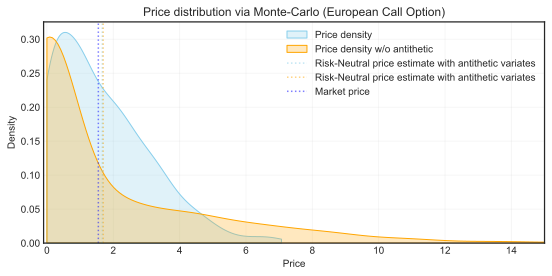

In [165]:
# Plot density
plt.figure(figsize=(9, 4))
sns.kdeplot(0.5 * (disc_payoffs_1 + disc_payoffs_2), bw_adjust=1.2,
            fill=True, cut=(0.5 * (disc_payoffs_1 + disc_payoffs_2)).min(),
            color='skyblue', label='Price density')

sns.kdeplot(discounted_payoffs, bw_adjust=1.2, fill=True,
            cut=discounted_payoffs.min(), color='orange', label='Price density w/o antithetic')

plt.axvline(price_estimate_anti, alpha = 0.5, color='skyblue', linestyle='dotted',
            label='Risk-Neutral price estimate with antithetic variates')

plt.axvline(price_estimate, alpha = 0.5, color='orange', linestyle='dotted',
            label='Risk-Neutral price estimate with antithetic variates')

plt.axvline(market_price, alpha = 0.5, color='blue', linestyle='dotted', label='Market price')
plt.xlim(-0.1, 15)

plt.title("Price distribution via Monte-Carlo (European Call Option)")
plt.xlabel("Price")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha = 0.2)
plt.show()

#### 1.3.2 Multi-Step Monte-Carlo with antithetic variates
----

In [166]:
# variables 
#N = 100 # number of time-steps 
dt = T/N

mudt = (r - 0.5 * sigma**2) * dt 

voldt = sigma * np.sqrt(dt)
lnS0 = np.log(S0)

# initial values for the sum of all Call pay-offs and its squre
sum_CT = 0
sum_CTsq = 0

for i in range(M):
    
    lnSt1 = lnS0
    lnSt2 = lnS0
    
    # add time increments of the log-process for each time step 
    for j in range(N):
        
        # using negatively correlated log-returns
        z = np.random.normal()
        lnSt1 += mudt + voldt * z
        lnSt2 += mudt - voldt * z
    
    # get the final stock price for each sim
    S_T1, S_T2 = np.exp(lnSt1), np.exp(lnSt2)
    # get the option pay-off for each sim 
    C_T = 0.5 * (np.maximum(S_T1 - K, 0) + np.maximum(S_T2 - K, 0))
    
    # add the results of each simulation
    sum_CT += C_T
    sum_CTsq += C_T ** 2
    
# price as the discounted average pay-off

call_price = (sum_CT/M) * np.exp(-r * T)

std = np.sqrt((sum_CTsq - (sum_CT**2)/M) * np.exp(-2*r*T) / (M - 1)) 

standard_error = std / np.sqrt(M)


print(f"Multi-step MC with antithetic variates")
print('----------------------------------------')
print(f"Estimate for Call Price on TD struck at {K}: {call_price:.4f} +/- {standard_error:.4f}")        


Multi-step MC with antithetic variates
----------------------------------------
Estimate for Call Price on TD struck at 65: 1.6784 +/- 0.0485


#### 1.3.3 Vectorized MC with antithetic variates for European Option pricing
----

In [167]:
#N = 10 # time-step can be 1
        # European vanilla options are path independent!
        
init_time = time.time()
        
dt = T/N
mudt = (r - 0.5 * sigma**2) * dt 
voldt = sigma * np.sqrt(dt)
lnS0 = np.log(S0)


# vectorized Monte Carlo

Z = np.random.normal(size = (N,M))

delta_lnSt1 = mudt + voldt * Z
delta_lnSt2 = mudt - voldt * Z

# cumuluative sum over the time axis, shape 1 x M
lnSt1 = lnS0 + np.cumsum(delta_lnSt1, axis = 0) 
lnSt2 = lnS0 + np.cumsum(delta_lnSt2, axis = 0)

# add the first row of the matix as the initial log price
lnSt1 = np.concatenate((np.full(shape = (1,M), fill_value=lnS0), lnSt1)) 
lnSt2 = np.concatenate((np.full(shape = (1,M), fill_value=lnS0), lnSt2)) 

# stock prices at the maturity
S_T1, S_T2 = np.exp(lnSt1), np.exp(lnSt2)

# option pay-offs
C_T = 0.5 * (np.maximum(S_T1 - K, 0) + np.maximum(S_T2 - K, 0))
   
# price as the discounted expected pay-off at T  
C_0 = np.exp(-r*T) * (np.sum(C_T[-1])/M)

# std error of estimates  
std = np.sqrt( np.sum((C_T[-1] * np.exp(-r*T) - C_0)**2) / (M - 1)) 
se_anti = std / np.sqrt(M)

mc_anti_time = time.time()-init_time


print("Vectorized Multi-step MC with antithetic variates")
print("---------------------------------------------------_")
print(f"Estimate for Call Price on TD struck at {K}: {C_0:.4f} +/- {se_anti:.4f}")    
print(f"Computation time: {mc_anti_time:.4f}")   

Vectorized Multi-step MC with antithetic variates
---------------------------------------------------_
Estimate for Call Price on TD struck at 65: 1.7379 +/- 0.0498
Computation time: 0.0068


**Note:** Earlier we have plotted the distribution of prices from a number of simulations which showed a right skewed distribution due to asymmetric pay-off of call options. However, this does **NOT MEAN** that the estimate $\hat{C}_{\rm MC}$ we derive from these $M$ simulations, which is also a random variable, will also have a skewed distribution. In fact, we expect that the MC estimator, which is given as an average of i.i.d distributed random ($M$ number of) pay-offs, to be normally distributed due to CLT. 

### 1.4 **Variance reduction via control variates**
---

The high level idea in control variates method of variance reduction rely on the use of a correlated random variable with known expected value to adjust the original estimator and reduce its variance.

Here, we will specifically focus on the Delta-based control variates, where the control variable is the stock price itself, and we use the option's Delta to determine how sensitive the option value is to fluctuations in the stock price.

Recall the for a European option, we essentially only need to simulate stock price at the maturity, i.e $S_T^{(n)}$ for each simulation $n$. This is the source of randomness in the option value, parametrized by the random variable across simulations:

$$
C_0^{(n)} = \mathrm{e}^{-rT}\, \textrm{max}((S_T^{(n)} - K)^{+}, 0 ),\quad\quad\quad n = 1,2,\dots,M
$$

summing over a number $M$ of realization of this random variable and dividing by $M$ gives us the standard Monte-Carlo estimator. 

To define the delta-based control variate estimator, we utilize the terminal stock price as the control variable $X = S_T^{(n)}$ which has a known expectation value in the risk-neutral world we are operating: 

$$
\mathbb{E}_{\mathbb{Q}}[S_T^{(n)}] = \mathbb{E}_{\mathbb{Q}}[S_T] = S_0\,\mathrm{e}^{rT}, \quad\quad\quad\quad\quad\quad\quad\quad\quad (0)
$$

Then we construct the control variate estimator 

$$
\hat{C}_{0,{\rm cv}} = \frac{1}{M} \sum_{n = 1}^{M} \left[C_0^{(n)} - \beta \left(X - \mathbb{E}_{\mathbb{Q}}[X]\right)\right], \quad\quad\quad\quad\quad\quad\quad\quad\quad (1)
$$

which is also unbiased. Computing the variance of this estimator: 

$$
\mathbb{V}[\hat{C}_{0,{\rm cv}}] = \frac{1}{M} \left(\mathbb{V}[C_0^{(n)}] + \beta^2\, \mathbb{V}[X] + 2 \beta\, \textrm{Cov}(C_0^{(n)}, X)\right)
$$

control variate coefficient that minimizes this variance is thus given by 

$$
\beta^{*} = \frac{\textrm{Cov}(C_0^{(n)}, X)}{\mathbb{V}[X]}, \quad\quad\quad\quad\quad\quad\quad\quad\quad (2)
$$

Since the discounted pay-off is positively correlated with the terminal stock price, the ideal $\beta^{*}$ is always positive, leading to an overall variance reduction for the estimator as compared to the standard MC estimator. 

In eq. (1), $\beta$ can be also seen as the amount of stock we should hold in order to hedge our long position in the call option. Recall that this is the standard approach that renders to portfolio risk-less which is instrumental for the derivation of the Black-Scholes equation describing the fair value of an option within the risk neutral framework. On the other hand, from the perspective of eq. (2), $\beta^{*}$ appear to be the best linear predictor of the (discounted) option payoff from $S_T$, i.e when $C_0$ regressed onto $X = S_T$:

$$
C_0 = \alpha + \beta^{*} S_T.
$$

We can in fact derive a rough relation between $\beta^{*}$ and delta of the call option, which is essentially the amount of stock we should decide to hold at $t = 0$, in order to hedge the uncertainty associated with the option's value at $t = T$. From the expression above, notice that we have 

$$
\frac{\partial \mathbb{E}_{\mathbb{Q}}[C_0]}{\partial \mathbb{E}_{\mathbb{Q}}[S_T]} = \beta^{*}
$$

Using eq. (0) and the definition of the delta, $\Delta_0 \equiv \partial C_0 / \partial{S}_0$, this gives us 

$$
\beta^{*} = \frac{\partial \mathbb{E}_{\mathbb{Q}}[C_0]}{\partial \mathbb{E}_{\mathbb{Q}}[S_T]} = \mathrm{e}^{-rT} \frac{\partial C_0}{\partial S_0}  = \mathrm{e}^{-rT}\, \Delta_0,
$$

and thus establishing the connection between the control variate coefficient and delta of the option contract. In eq (1), this gives us the final relation for delta based control variate estimator: 

$$
\hat{C}_{0,{\rm cv}} = \frac{\mathrm{e}^{-rT}}{M} \sum_{n = 1}^{M} \left[C_T^{(n)} - \Delta_0 \left(S_T^{(n)} - S_0\,\mathrm{e}^{rT}\right)\right], \quad\quad\quad\quad\quad\quad\quad\quad\quad (3)
$$

where $\left(S_T^{(n)} - S_0\,\mathrm{e}^{rT}\right)$ is the control variate. As appear in the eq. (3), we use the gain (which is equivalent to the control variate) from buying $\Delta_0$ of shares at time $t = 0$ and holding it until $t = T$, in order to hedge the risk/variance of the portfolio!

To determine the premium of a vanilla European option, it is sufficient to simulate $M$ different option pay-off and underling stock price to reduce the variance with the knowledge of delta at the initial time. 

$$
\Delta(r,S,K,T,\sigma) = \mathcal{N}(d_1),\quad\quad\quad d_1 = \frac{\ln(S/K) + (r + \sigma^2 / 2)T}{\sigma \sqrt{T}}
$$

in the Black-Scholes world.

However, the real promise of the control variate method is its connection with hedging which is carried out dynamically in the real world, for example by rebalancing our stock positions according to the movements in the market. We can introduce the time dimension into our control variate estimator by generalizing the second term in eq. (3). For this purpose, we will consider $N$ time steps rather than $N = 1$ that partitions the interval $[0,T]$ into steps of size $\Delta t = T/N$ where: 

$$
0 = t_0 < t_1 < t_2 < \dots < t_N =T
$$

Since the pay-off is path independent, we do not need to introduce any modification in the first term of eq. (3), and adding the necessary time dimension that takes into account incremental changes in the stock position and the control variate, we obtain 

$$
\hat{C}_{0,{\rm cv}} = \frac{\mathrm{e}^{-rT}}{M} \sum_{n = 1}^{M} \left[C_T^{(n)} - \sum_{j = 0}^{N-1} \Delta_{t_j} \left(S_{t_{j+1}}^{(n)} - S_{t_j}^{(n)}\,\mathrm{e}^{r \Delta t}\right)\right], \quad\quad\quad\quad\quad\quad\quad\quad\quad (3)
$$

In [168]:
def option_delta(r,S,K,T,sigma,type = 'c'):
    
    d1 = (np.log(S/K) + (r + sigma ** 2/2) * T) / (sigma * np.sqrt(T))
    
    try: 
        
        if type == 'c':
            
            delta = stats.norm.cdf(d1,0,1)
            
        elif type == 'p':
            
            delta = -stats.norm.cdf(-d1,0,1) 
            
        return delta
    
    except: 
        
        print('Please confirm your option type, "c" for calls and "p" for puts')       

In [169]:
Z = np.random.normal(0, 1, M)

ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

payoffs, cvs = np.maximum(ST - K, 0), (ST - S0 * np.exp(r*T))

price_estimate_cv = np.mean(payoffs - option_delta(r,S0,K,T,sigma) * cvs)

SE_cv = np.std(payoffs - option_delta(r,S0,K,T,sigma) * cvs, ddof=1) / np.sqrt(M)

print("Single-step MC using control variate")
print("------------------------------------")
print(f"Estimate for Call Price on TD struck at {K}: {price_estimate_cv:.4f} +/- {SE_cv:.4f}")

Single-step MC using control variate
------------------------------------
Estimate for Call Price on TD struck at 65: 1.7723 +/- 0.0488


#### 1.4.1 Multi-time step MC with control variate 
-------

In [170]:
#N = 50 # change to see the effect on se if you like 
dt = T/N

mudt = (r - 0.5 * sigma**2) * dt 
erdt = np.exp(r * dt)

voldt = sigma * np.sqrt(dt)

# initial values for the sum of all Call pay-offs and its squre
sum_CT = 0
sum_CTsq = 0

for i in range(M):
    
    St = S0
    tot_control_var = 0
    
    # add time increments of the log-process for each time step 
    for j in range(N):
        
        z = np.random.normal()
        # option delta at time t
        deltat = option_delta(r,St,K, T-j*dt, sigma) 
        # stock price at t+dt
        Stpdt = St * np.exp(mudt + voldt * z)
        tot_control_var += deltat * (Stpdt - St * erdt)
        #update the stock price
        St = Stpdt 
        
    
    # get the option pay-off for each sim 
    C_T = np.maximum(St - K, 0) - tot_control_var
    
    # add the results of each simulation
    sum_CT += C_T
    sum_CTsq += C_T ** 2
    
# price as the discounted average pay-off

call_price = (sum_CT/M) * np.exp(-r * T)

std = np.sqrt((sum_CTsq - (sum_CT**2)/M) * np.exp(-2*r*T) / (M - 1)) 

standard_error = std / np.sqrt(M)


print(f"Multi-step MC with control variates")
print('----------------------------------------')
print(f"Estimate for Call Price on TD struck at {K}: {call_price:.4f} +/- {standard_error:.4f}")        

Multi-step MC with control variates
----------------------------------------
Estimate for Call Price on TD struck at 65: 1.7235 +/- 0.0072


Notice that the variance is consistently reduced! If we increase the number of time steps it will reduce further! Finally let's vectorize the control variate method...

#### 1.4.2 Multi-step vectorized MC with control variates
-------

In [171]:
#N = 100 # change to see the effect on se and computation time

init_time = time.time()

dt = T/N
mudt = (r - 0.5 * sigma**2) * dt 
voldt = sigma * np.sqrt(dt)
lnS0 = np.log(S0)

erdt = np.exp(r * dt)
control_var = 0

# vectorized Monte Carlo

Z = np.random.normal(size = (N,M))

# log-process of stock
delta_lnSt = mudt + voldt * Z

# shape N x M
St = S0 * np.cumprod(np.exp(delta_lnSt), axis = 0) 

# add the first row of the matix as the initial price
St = np.concatenate((np.full(shape = (1,M), fill_value=S0), St)) 

# get delta of option, no delta hedging at the last time step
delta = option_delta(r,St[:-1].T, K, np.linspace(T,0,N+1)[:-1],sigma).T

control_var = np.cumsum(delta * (St[1:]- St[:-1] * erdt), axis = 0) 

# option pay-offs for different sims
C_T = np.maximum(St[-1] - K, 0) - control_var[-1]
   
# price as the discounted expected pay-off at T  
call_price= np.exp(-r*T) * np.sum(C_T)/M


# standard error of estimate    
std = np.sqrt( np.sum((C_T * np.exp(-r*T) - C_0)**2) / (M - 1)) 
se_cv = std / np.sqrt(M)

mc_cv_time = time.time() - init_time

print("Vectorized Multi-step MC with control variates")
print("---------------------------------------------------_")
print(f"Estimate for Call Price on TD struck at {K}: {call_price:.4f} +/- {se_cv:.4f}")   
print(f"Computation time: {mc_cv_time:.4f}")       

Vectorized Multi-step MC with control variates
---------------------------------------------------_
Estimate for Call Price on TD struck at 65: 1.7252 +/- 0.0073
Computation time: 0.0077


####  1.4.3 Generalizing control variate (CV) method and Gamma based CV method
------  

We can extend the logic of eq. (3) to incorporate more than one cvs (and in fact mixing different type of variance reduction methods), by introducing another dimensionality in the space of control variate. For example, ignoring sampling domain of the MC simulations and the time domain of the control variate, we can generalize the eq. (3) schematically as: 

$$
\hat{C}_{0,{\rm cv}}\, \mathrm{e}^{rT} = \hat{C}_T - \sum_{k = 1}^K  \beta_k\, \rm{cv}_k + \epsilon,\quad\quad\quad\quad\quad\quad eq.(4),
$$

where $\hat{C}_T$ is the standard MC estimate of the pay-off. In eq. (4), we can interpret $\beta_k$ as the factors that determines the "true" relationship between the option's pay-off $C_T$ and the control variate $\rm{cv}_k$. We also introduced error term $\epsilon$ to emphasize the linear regression problem implied by eq. (4). $\epsilon$ accounts for errors due to 

- discrete re-balancing (recall the way we performed the delta based cv method)
- the level of truncation we utilize for hedge sensitivities (for example, delta, gamma, ...)

These ideas bring us towards **Gamma based control variate method** which is really the next to leading order hedging strategy one would carry to reduce the risk associated by our position on the option. 

#### 1.4.4 Gamma based control variate
----

Similar to the delta sensitivity we considered, we can include hedging considering the next order sensitivity of the option to the underlying via:

$$
\Gamma \equiv \frac{\partial^2 C}{\partial S^2}.
$$

In analogy with the delta based control variate in eq. (3): 

$$
\textrm{cv}_{2} = \sum_{j = 0}^{N-1} \Gamma_{t_j} \left(\Delta S_{j}^2 - \mathbb{E}_{Q}[\Delta S_{j}^2]\right),
$$

where we define the finite difference of the stock price at time step $j$ as 

$$
\Delta S_j = S_{t_{j+1}} - S_{t_{j}}. 
$$

Recalling the solution to the stock price under GBM within a unit time interval $\Delta t  = t_{j+1} - t_{j}$:

$$
S_{t_{j+1}} = S_{t_{j}}\, \mathrm{e}^{(r - \sigma^2/2)\,\Delta t + \sigma \sqrt{\Delta t} Z},\quad\quad Z \sim \mathcal{N}(0,1)
$$

it is easy to show that the expectation of square difference in the stock price read as 

$$
\mathbb{E}_{\mathbb{Q}}[\Delta S_j^2] = S_{t_j}^2 \left(\mathrm{e}^{(2 r + \sigma^2) \Delta t} - 2\, \mathrm{e}^{r \Delta t} + 1\right).
$$

In order to implement this method we will define Gamma of the option in the BS world which is the same for calls and puts as it measures the convexity!

$$
\Gamma(S,t) = \frac{N(d_1)}{S \sigma \sqrt{T-t}}
$$

In [172]:
def option_gamma(r,S,K,T,sigma):
    
    d1 = (np.log(S/K) + (r + sigma ** 2/2) * T) / (sigma * np.sqrt(T))
    
    gamma = stats.norm.pdf(d1, 0, 1) / (S * sigma * np.sqrt(T))
    
    return gamma         

In [173]:
#N = 100 # change to see the effect on se and computation time

init_time = time.time()

dt = T/N
mudt = (r - 0.5 * sigma**2) * dt 
voldt = sigma * np.sqrt(dt)
lnS0 = np.log(S0)

gamma_factor = np.exp((2 * r + (sigma ** 2)) * dt) - 2 * np.exp(r * dt) + 1

# vectorized Monte Carlo

Z = np.random.normal(size = (N,M))

# log-process of stock
delta_lnSt = mudt + voldt * Z

# shape N x M
St = S0 * np.cumprod(np.exp(delta_lnSt), axis = 0) 

# add the first row of the matix as the initial price
St = np.concatenate((np.full(shape = (1,M), fill_value=S0), St)) 

# get gamma of the option: no gamma hedging at the last time step
gamma = option_gamma(r,St[:-1].T, K, np.linspace(T,dt,N),sigma).T

control_var = np.cumsum(gamma * ( (St[1:]- St[:-1]) ** 2 - gamma_factor * St[:-1] ** 2), axis = 0) 

# option pay-offs for different sims
C_T = np.maximum(St[-1] - K, 0) - 0.5 * control_var[-1] # 0.5 comes from taylor expansion 
   
# price as the discounted expected pay-off at T  
call_price= np.exp(-r*T) * np.sum(C_T)/M


# standard error of estimate    
std = np.sqrt( np.sum((C_T * np.exp(-r*T) - C_0)**2) / (M - 1)) 
se_cv_g = std / np.sqrt(M)

mc_cv_g_time = time.time() - init_time

print("Vectorized Multi-step MC with gamma based control variates")
print("------------------------------------------------------------")
print(f"Estimate for Call Price on TD struck at {K}: {call_price:.4f} +/- {se_cv_g:.4f}")   
print(f"Computation time: {mc_cv_g_time:.4f}")       

Vectorized Multi-step MC with gamma based control variates
------------------------------------------------------------
Estimate for Call Price on TD struck at 65: 1.7110 +/- 0.0868
Computation time: 0.0077


As expected the improvement with respect standard MC method is tiny as we are looking for a second order effect! 

Just as we could use together delta and gamma based control variates to reduce the variance on the option price estimate, we can combine them with different methods such as the antithetic variate method! As a starting example, let's consider antithetic variates with delta based control variate 




#### Antithetic + Delta based control variates
-----

If we consider antithetic and delta based control variates together, we have the following estimator

$$
\hat{C}_{0,{\rm cva}}\, \mathrm{e}^{rT} = \frac{1}{2M} \sum_{n = 1}^{M} \left[\,\hat{C}_T(Z^{(n)}) + \hat{C}_T(-Z^{(n)})\,\right]  - \beta_{\Delta}\sum_{n = 1}^{M} \, \rm{cv}^{(n)}_{\Delta},
$$

where $\beta_{{\Delta}} = 1$ and 

$$
\textrm{cv}_{\Delta} = \frac{1}{2} \left(\textrm{cv}_{1\Delta} + \textrm{cv}_{2\Delta}\right), 
$$

where indices $n$ for each simulation is implied in the expression above. Notice that we take into account a control variate for each of the antithetic variates:

$$
\textrm{cv}_{1,\Delta} = \sum_{j = 0}^{N-1}\Delta_{1,t_{j}} \left(S_{1,t_{j + 1}} - \mathbb{E}[S_{1,t_{j + 1}}]\right)
$$

$$
\textrm{cv}_{2,\Delta} = \sum_{j = 0}^{N-1}\Delta_{2,t_{j}} \left(S_{2,t_{j + 1}} - \mathbb{E}[S_{2,t_{j + 1}}]\right)
$$

In [174]:
#N = 10 # time-step can be 1
        # European vanilla options are path independent!
        
init_time = time.time()
        
dt = T/N
mudt = (r - 0.5 * sigma**2) * dt 
voldt = sigma * np.sqrt(dt)
lnS0 = np.log(S0)
erdt = np.exp(r * dt)


# vectorized Monte Carlo

Z = np.random.normal(size = (N,M))

delta_lnSt1 = mudt + voldt * Z
delta_lnSt2 = mudt - voldt * Z

# cumuluative sum over the time axis, shape 1 x M
lnSt1 = lnS0 + np.cumsum(delta_lnSt1, axis = 0) 
lnSt2 = lnS0 + np.cumsum(delta_lnSt2, axis = 0)

# add the first row of the matix as the initial log price
lnSt1 = np.concatenate((np.full(shape = (1,M), fill_value=lnS0), lnSt1)) 
lnSt2 = np.concatenate((np.full(shape = (1,M), fill_value=lnS0), lnSt2)) 

# stock prices at the maturity
S_T1, S_T2 = np.exp(lnSt1), np.exp(lnSt2)

# get deltas: no delta hedging at the last time step S_T[:-1]
delta1 = option_delta(r,S_T1[:-1].T, K, np.linspace(T,dt,N),sigma).T
delta2 = option_delta(r,S_T2[:-1].T, K, np.linspace(T,dt,N),sigma).T

cvar1 = np.cumsum(delta1 * (S_T1[1:]- S_T1[:-1] * erdt), axis = 0) 
cvar2 = np.cumsum(delta2 * (S_T2[1:]- S_T2[:-1] * erdt), axis = 0) 

# option pay-offs
C_T = 0.5 * (np.maximum(S_T1[-1] - K, 0) + np.maximum(S_T2[-1] - K, 0)) - 0.5 * (cvar1[-1] + cvar2[-1])

# price as the discounted expected pay-off at T  
C_0 = np.exp(-r*T) * (np.sum(C_T)/M)

# std error of estimates  
std = np.sqrt( np.sum((C_T * np.exp(-r*T) - C_0)**2) / (M - 1)) 
se_anti_cv = std / np.sqrt(M)

mc_anti_cv_time= time.time()-init_time


print("Vectorized Multi-step MC with antithetic + delta based control variates")
print("-------------------------------------------------------------------------")
print(f"Estimate for Call Price on TD struck at {K}: {C_0:.4f} +/- {se_anti_cv:.4f}")    
print(f"Computation time: {mc_anti_cv_time:.4f}")   

Vectorized Multi-step MC with antithetic + delta based control variates
-------------------------------------------------------------------------
Estimate for Call Price on TD struck at 65: 1.7166 +/- 0.0071
Computation time: 0.0106


#### Antithetic + Delta + Gamma based control variates
-----

If we combine all the variance reduction techniques we studies so far, we need to consider the following estimator: 

$$
\hat{C}_{0,{\rm cvag}}\, \mathrm{e}^{rT} = \frac{1}{2M} \sum_{n = 1}^{M} \left[\,\hat{C}_T(Z^{(n)}) + \hat{C}_T(-Z^{(n)})\,\right]  - \beta_{\Delta}\sum_{n = 1}^{M} \, \rm{cv}^{(n)}_{\Delta} - \beta_{\Gamma}\sum_{n = 1}^{M} \, \rm{cv}^{(n)}_{\Gamma},
$$

where $\beta_{{\Delta}} = 1$, $\beta_{{\Gamma}} = 0.5$ and 

$$
\textrm{cv}_{\Delta} = \frac{1}{2} \left(\textrm{cv}_{1\Delta} + \textrm{cv}_{2\Delta}\right), 
$$

$$
\textrm{cv}_{\Gamma} = \frac{1}{2} \left(\textrm{cv}_{1\Gamma} + \textrm{cv}_{2\Gamma}\right), 
$$

where indices $n$ for each simulation is implied in the expression above. Notice that we consider both delta and gamma control variates for each of the antithetic variates:

$$
\textrm{cv}_{1,\Delta} = \sum_{j = 0}^{N-1}\Delta_{1,t_{j}} \left(S_{1,t_{j + 1}} - \mathbb{E}[S_{1,t_{j + 1}}]\right)
$$

$$
\textrm{cv}_{2,\Delta} = \sum_{j = 0}^{N-1}\Delta_{2,t_{j}} \left(S_{2,t_{j + 1}} - \mathbb{E}[S_{2,t_{j + 1}}]\right)
$$

$$
\textrm{cv}_{1,\Gamma} = \sum_{j = 0}^{N-1}\Gamma_{1,t_{j}} \left(\Delta S_{1,{j}}^2 - \mathbb{E}[\Delta S_{1,{j}}^2]\right)
$$

$$
\textrm{cv}_{2,\Gamma} = \sum_{j = 0}^{N-1}\Gamma_{2,t_{j}} \left(\Delta S_{2,t_{j}}^2 - \mathbb{E}[\Delta S_{2,t_{j}}^2]\right)
$$

In [175]:
#N = 10 # time-step can be 1
        # European vanilla options are path independent!
        
init_time = time.time()
        
dt = T/N
mudt = (r - 0.5 * sigma**2) * dt 
voldt = sigma * np.sqrt(dt)
lnS0 = np.log(S0)
erdt = np.exp(r * dt)
gamma_factor = np.exp((2 * r + (sigma ** 2)) * dt) - 2 * np.exp(r * dt) + 1


# vectorized Monte Carlo

Z = np.random.normal(size = (N,M))

delta_lnSt1 = mudt + voldt * Z
delta_lnSt2 = mudt - voldt * Z

# cumuluative sum over the time axis, shape 1 x M
lnSt1 = lnS0 + np.cumsum(delta_lnSt1, axis = 0) 
lnSt2 = lnS0 + np.cumsum(delta_lnSt2, axis = 0)

# add the first row of the matix as the initial log price
lnSt1 = np.concatenate((np.full(shape = (1,M), fill_value=lnS0), lnSt1)) 
lnSt2 = np.concatenate((np.full(shape = (1,M), fill_value=lnS0), lnSt2)) 

# stock prices at the maturity
S_T1, S_T2 = np.exp(lnSt1), np.exp(lnSt2)

# get deltas: no delta hedging at the last time step S_T[:-1]
delta1 = option_delta(r,S_T1[:-1].T, K, np.linspace(T,dt,N),sigma).T
delta2 = option_delta(r,S_T2[:-1].T, K, np.linspace(T,dt,N),sigma).T

# get gammas: no gamma hedging at the last time step
gamma1 = option_gamma(r,S_T1[:-1].T, K, np.linspace(T,dt,N),sigma).T
gamma2 = option_gamma(r,S_T2[:-1].T, K, np.linspace(T,dt,N),sigma).T

# control variates
cvar_d1 = np.cumsum(delta1 * (S_T1[1:]- S_T1[:-1] * erdt), axis = 0) 
cvar_d2 = np.cumsum(delta2 * (S_T2[1:]- S_T2[:-1] * erdt), axis = 0) 

cvar_g1 = np.cumsum(gamma1 * ( (S_T1[1:]- S_T1[:-1]) ** 2 - gamma_factor * S_T1[:-1] ** 2), axis = 0)
cvar_g2 = np.cumsum(gamma2 * ( (S_T2[1:]- S_T2[:-1]) ** 2 - gamma_factor * S_T2[:-1] ** 2), axis = 0) 
 
# option pay-offs across M simulations
C_T = 0.5 * (np.maximum(S_T1[-1] - K, 0) + np.maximum(S_T2[-1] - K, 0) - (cvar_d1[-1] + cvar_d2[-1])
             - 0.5 * (cvar_g1[-1] + cvar_g2[-1]))

# price as the discounted expected pay-off at T  
C_0 = np.exp(-r*T) * (np.sum(C_T)/M)

# std error of estimates  
std = np.sqrt( np.sum((C_T * np.exp(-r*T) - C_0)**2) / (M - 1)) 
se_anti_cvall = std / np.sqrt(M)

mc_anti_cvall_time = time.time()-init_time


print("Vectorized Multi-step MC with antithetic + delta + gamma based control variates")
print("-------------------------------------------------------------------------")
print(f"Estimate for Call Price on TD struck at {K}: {C_0:.4f} +/- {se_anti_cvall:.4f}")    
print(f"Computation time: {mc_anti_cvall_time:.4f}")   

Vectorized Multi-step MC with antithetic + delta + gamma based control variates
-------------------------------------------------------------------------
Estimate for Call Price on TD struck at 65: 1.7309 +/- 0.0011
Computation time: 0.0154


Notice that combining all the variance reduction method effectively reduced the standard error of the estimation! However, the computation time is increased! There is always a trade-off between accuracy and computation time.

In [ ]:
se_list = [se, se_anti, se_cv, se_cv_g, se_anti_cv, se_anti_cvall]

# relative se reduction factors w.r.t standard MC
se_reduc_factor = [round(se/std,2) for std in se_list]

calc_time = [mc_time, mc_anti_time, mc_cv_time, mc_cv_g_time, mc_anti_cv_time, mc_anti_cvall_time]

# get relative computation time w.r.t standard MC
rel_calc_time = [round(ct/mc_time,2) for ct in calc_time]

dict = {'Standard Error (SE)': se_list,
        'SE reduction factor': se_reduc_factor, 'Relative Computation time': rel_calc_time}

trade_off_df = pd.DataFrame(dict, index = ['MC estimate', 'MC + Antithetic', 'MC + DCV', 'MC + GCV',
                                           'MC + Antithetic + DCV', 'MC + Antithetic + DCV + GCV'])

trade_off_df


,Standard Error (SE),SE reduction factor,Relative Computation time
MC estimate,0.088670,1.00,1.00
MC + Antithetic,0.049839,1.78,1.36
MC + DCV,0.007324,12.11,1.55
MC + GCV,0.086780,1.02,1.54
MC + Antithetic + DCV,0.007133,12.43,2.13
MC + Antithetic + DCV + GCV,0.001124,78.86,3.08


In [8]:
from mc_models import MonteCarloSimulator


sim_gbm = MonteCarloSimulator(S0=100, T=1, r=0.05, n_paths=10000, n_steps=252,
                          model_type='GBM', model_params={'sigma': 0.2})
call_payoff = lambda ST: np.maximum(ST - 100, 0)
price = sim_gbm.price_option(call_payoff)

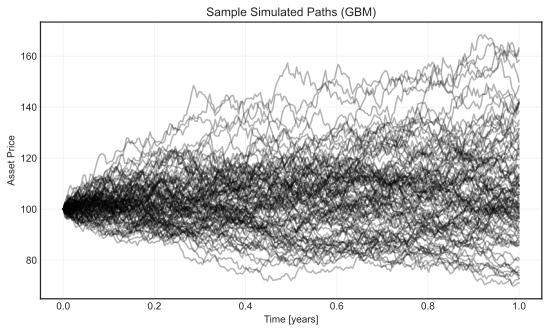

In [9]:
sim_gbm.plot_paths(n = 100)

In [12]:
sim_heston = MonteCarloSimulator(
    S0=100, r=0.05, T=1, n_steps=252, n_paths=1000,
    model_type='Heston',
    model_params={'v0': 0.25**2, 'kappa': 3.0,'theta': 0.05, 'xi': 0.6, 'rho': -0.7
    }
)

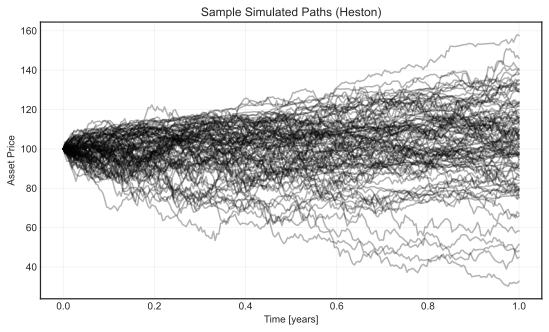

In [13]:
sim_heston.plot_paths(n =100)

In [84]:
# leverage effect 

# Parameters
# simulation dependent
S0 = 100.0             # asset price
T = 1.0                # time in years
r = 0.02               # risk-free rate
N = 252                # number of time steps in simulation
M = 1000               # number of simulations

# Heston dependent parameters
kappa = 3              # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2        # long-term mean of variance under risk-neutral dynamics
v0 = 0.25**2           # initial variance under risk-neutral dynamics
xi = 0.6            # volatility of volatility

rhop = 0.98
rhom = -0.98


heston_sim_rhop = MonteCarloSimulator(S0=S0, T=1, r=r, n_paths=M, n_steps=N,
                          model_type='Heston', model_params={'v0': v0, 
                                                             'kappa': kappa,'theta': theta,
                                                             'xi': xi, 'rho': rhop })

heston_sim_rhom = MonteCarloSimulator(S0=S0, T=1, r=r, n_paths=M, n_steps=N,
                          model_type='Heston', model_params={'v0': v0, 
                                                             'kappa': kappa,'theta': theta,
                                                             'xi': xi, 'rho': rhom})

S_paths_heston_rhop = heston_sim_rhop._simulate_heston()
S_paths_heston_rhom = heston_sim_rhom._simulate_heston()

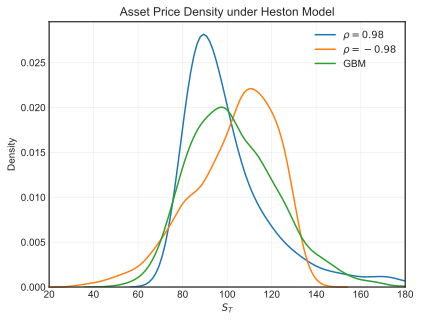

In [85]:

# simulate gbm process at time T
gbm = S0*np.exp( (r - theta**2/2)*T + np.sqrt(theta)*np.sqrt(T)*np.random.normal(0,1,M) )

fig, ax = plt.subplots()

ax = sns.kdeplot(S_paths_heston_rhop[:,-1], label=r"$\rho= 0.98$", ax=ax)
ax = sns.kdeplot(S_paths_heston_rhom[:,-1], label=r"$\rho= -0.98$", ax=ax)
ax = sns.kdeplot(gbm , label="GBM", ax=ax)

plt.title(r'Asset Price Density under Heston Model')
plt.xlim([20, 180])
plt.xlabel('$S_T$')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha = 0.3)


In [91]:

# Set strikes and complete MC option price for different strikes
K = np.arange(50,180,1)

heston_sim_rhop = MonteCarloSimulator(S0=S0, T=1, r=r, n_paths=M, n_steps=N,
                          model_type='Heston', model_params={'v0': v0, 
                                                             'kappa': kappa,'theta': theta,
                                                             'xi': xi, 'rho': -0.98 })

S_paths_heston_rhop = heston_sim_rhop._simulate_heston()

put_prices = np.array([np.exp(-r*T)*np.mean(np.maximum(k-S_paths_heston_rhop[:,-1],0)) for k in K])
call_prices = np.array([np.exp(-r*T)*np.mean(np.maximum(S_paths_heston_rhop[:,-1]-k,0)) for k in K])


In [92]:
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol

put_ivs = implied_vol(put_prices, S0, K, T, r, flag='p', q=0, return_as='numpy', on_error='ignore')
call_ivs = implied_vol(call_prices, S0, K, T, r, flag='c', q=0, return_as='numpy', on_error='ignore')


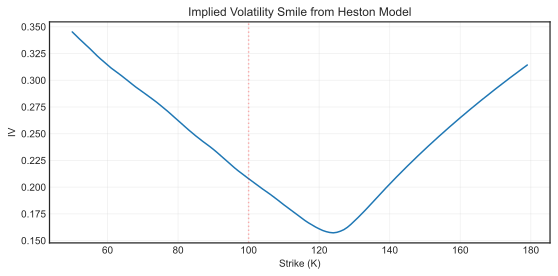

In [93]:
plt.figure(figsize= (9,4))

#plt.plot(K, call_ivs, label=r'IV calls')


plt.plot(K, put_ivs, label=r'IV puts')
plt.axvline(S0, color = 'red', ls = 'dotted', alpha = 0.3, label=r'current stock price')

plt.ylabel('IV')
plt.xlabel('Strike (K)')

plt.title('Implied Volatility Smile from Heston Model')
plt.grid(alpha = 0.3)